# DSCC 483: DATA SCIENCE CAPSTONE PRACTICUM
# ASSIGNMENT: MINI-PROJECT
# TEAM: EUGENE AYONGA & HOMAYRA TABASSUM
# DATE: 09/22/2024

## Part I: Descriptive Analysis (20 points)

In [3]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
import re
import h2o
import warnings
from h2o.automl import H2OAutoML
from time import time
from itertools import combinations
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.exceptions import DataConversionWarning
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# DOWNLOADS

# Downloading the necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
# INSTALLATIONS
%pip install h2o

#### *NOTE*: h2o requires a working installation of Java. Do the following on your command line

1) java -version # Check if Java is installed
   
2) Install Java on Ubuntu/Linux: 
    1. `sudo apt update`
    2. `sudo apt install default-jdk`
   
3) Install Java on macOS using Homebrew:
    1. `brew update`
    2. `brew install openjdk`
    3. `sudo ln -sfn $(brew --prefix openjdk)/libexec/openjdk.jdk /Library/Java/JavaVirtualMachines/openjdk.jdk`
   
4) java -version # Check Java version

In [4]:
# Exploratory Data Analysis (EDA)
# LOADING THE TRAINING DATA
df_train = pd.read_csv("./training_data.csv")
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
df_train.head(10)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999
5,8,b'This misguided decision threatens to rip hea...,vtpoli,3,2018,-0.378036,-0.407960
6,2,b'Overseeing the role of US armed forces in fo...,YemenCantWait,2,2019,-0.213925,0.178393
7,73,b'Way to GO @winthropu! \xf0\x9f\x8f\x80 \n\nF...,ROCKtheHILL,6,2020,0.801839,-0.346375
8,478,"b""As a single mother raising two sons, I relie...",HandsOffSNAP,219,2019,-0.681218,-0.555757
9,29,b'It was great to see to so many Arkansans las...,AR2,6,2017,0.407924,0.286922


In [ ]:
# LOADING THE TEST DATA
df_test = pd.read_csv("./test_data.csv")
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
df_test.head(10)

In [5]:
# Checking the shape
df_train.shape

(333987, 7)

In [6]:
# Checking the column names
list(df_train.columns)

['favorite_count',
 'full_text',
 'hashtags',
 'retweet_count',
 'year',
 'dim1_nominate',
 'dim2_nominate']

In [7]:
# Checking the data types
df_train.dtypes

favorite_count      int64
full_text          object
hashtags           object
retweet_count       int64
year                int64
dim1_nominate     float64
dim2_nominate     float64
dtype: object

In [8]:
# Missing values, filter columns with null values
len(df_train.isnull().sum()[lambda x: x > 0])

0

Verdict: No missing values in the training dataset (df_train)

# Section A
## (20 points for undergraduate students, 10 points for graduate students)

## QUESTION (a)

**Create a table that contains information on minimum, average, median, and maximum for the
following: tweet length (#characters and #words) (text column), hashtag length (#characters
and #words) (hashtags column) (Add your table to the report.) (4 points) (2 points for graduate
students)**

In [12]:
# Calculate tweet length in characters and words
df_train['tweet_length_characters'] = df_train['full_text'].apply(len)
df_train['tweet_length_words'] = df_train['full_text'].apply(lambda x: len(x.split()))

# Calculate hashtag length in characters and words (space-separated hashtags)
df_train['hashtag_length_characters'] = df_train['hashtags'].apply(lambda x: len(x.replace(' ', '')) if isinstance(x, str) else 0)
df_train['hashtag_length_words'] = df_train['hashtags'].apply(lambda x: len(x.split(' ')) if isinstance(x, str) else 0)

# Summary statistics
summary_table = pd.DataFrame({
    'tweet_length_characters': df_train['tweet_length_characters'].agg(['min', 'mean', 'median', 'max']),
    'tweet_length_words': df_train['tweet_length_words'].agg(['min', 'mean', 'median', 'max']),
    'hashtag_length_characters': df_train['hashtag_length_characters'].agg(['min', 'mean', 'median', 'max']),
    'hashtag_length_words': df_train['hashtag_length_words'].agg(['min', 'mean', 'median', 'max']),
})

# Display the summary table
summary_table

,tweet_length_characters,tweet_length_words,hashtag_length_characters,hashtag_length_words
min,7.000000,1.000000,1.000000,1.00000
mean,183.176139,24.885511,14.044142,1.49198
median,154.000000,21.000000,12.000000,1.00000
max,2437.000000,61.000000,168.000000,17.00000


## QUESTION (b)

**Find the top ten most commonly used hashtags (hashtags column). Then, create a bar chart
which show the count values of these ten most commonly used hashtags. Do you observe any
patterns? What are the meanings / interpretations of the hashtags you have identified? Write
your findings in the report. (Add the bar chart to the report.) (4 points) (2 points for graduate
students)**

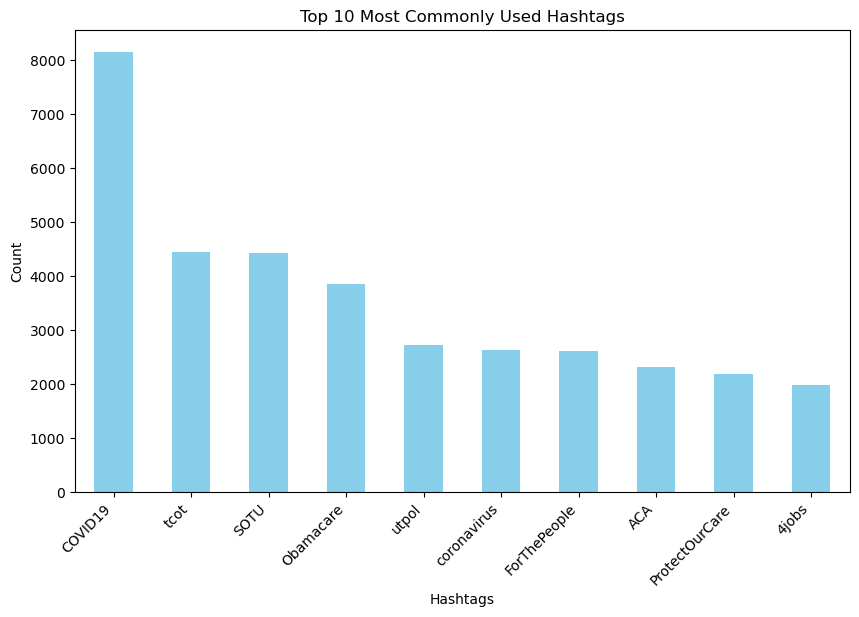

In [14]:
# Split and flatten the hashtags into a single list
all_hashtags = df_train['hashtags'].dropna().str.split().explode()

# Count the frequency of each hashtag
top_hashtags = all_hashtags.value_counts().head(10)

# Plot the top ten most commonly used hashtags
plt.figure(figsize=(10, 6))
top_hashtags.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Commonly Used Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

### Interpretation

From the Kaggle competition instruction, it is evident that the congressional twitter data covers a period between the years 2008 - 2020 and contains 469,740 tweets. The timeframe spans from the time President Barack Obama was elected in 2008 to the Covid-19 pandemic.

Here’s a breakdown of the nterpretations of the ten most commonly used hashtags:

1. **#COVID19 and #coronavirus**: Related to the global COVID-19 pandemic, indicating a significant focus on discussions around this topic.

2.	**#tcot**: Stands for “Top Conservatives on Twitter,” a hashtag often used by conservative users to connect.

3.	**#SOTU**: Refers to the “State of the Union” address by the USA president.

4.	**#Obamacare and #ACA**: Affordable Care Act(ACA) also known as Obamacare, reflecting discussions on President Obama's flagship healthcare policies.

5.	**#utpol**: Most likely stands for “Utah Politics,” suggesting a regional focus on political issues within Utah.

6.	**#ForThePeople**: Refers to the campaign slogan of the then U.S Senator from California, Kamala Harris when she vied for the 2020 presidential election.

7.	**#ProtectOurCare**: Refers to efforts in defense of healthcare rights, particularly in the context of the Affordable Care Act, when the 45th President of the United States ran on an agenda to quash Obamacare.

8.	**#4jobs**: Likely related to discussions around job creation and economic policies.

These hashtags indicate a strong focus on healthcare, economic policies, and the COVID-19 pandemic, reflecting the major issues of the time when these tweets were made.

## QUESTION (c)

To answer this question, first please read the description above DW-NOMINATE scores provided
at the beginning of this assignment document. Then, please divide your training dataset into four
subsets by focusing on the following ideological dimensions:

    a. Group 1: Dim 1 (0 to 1), Dim 2 (0 to 1)
    b. Group 2: Dim 1 (0 to 1), Dim 2 (0 to -1)
    c. Group 3: Dim 1 (0 to -1), Dim 2 (0 to 1)
    d. Group 4: Dim 1 (0 to -1), Dim 2 (0 to -1)

Repeat the same analysis you have done in part b). Please create four separate bar charts with
four different colors this time. Do you observe any patterns? Are your findings similar to or
different from your findings in part b) ?. Please explain. Write your findings in the report. (Add the bar charts to the report.) (4 points) (2 points for graduate students)

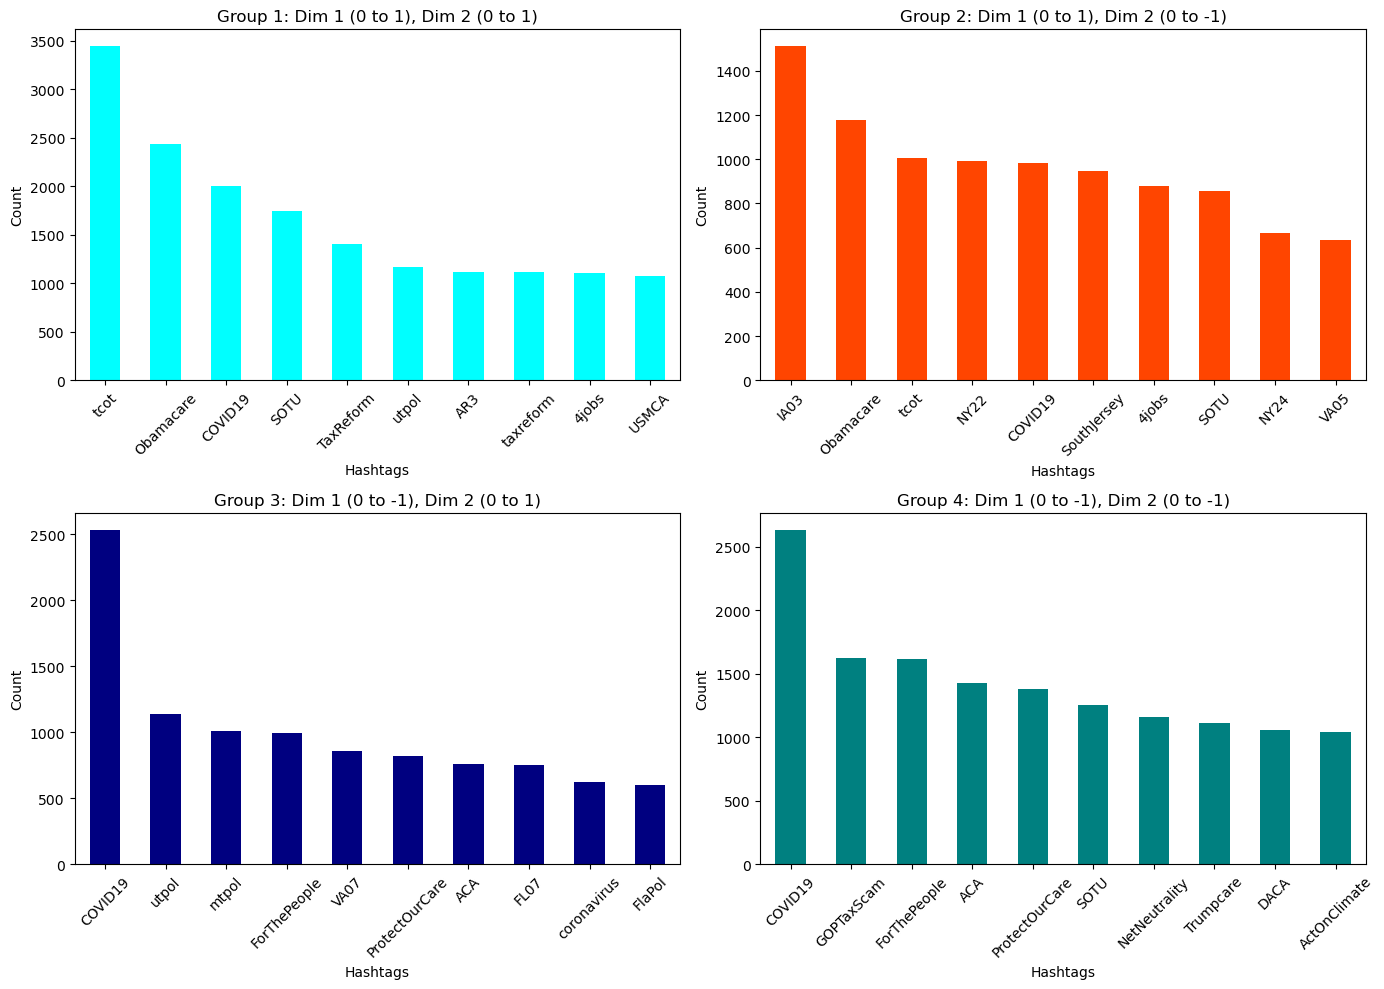

In [17]:
# Create the four groups based on the given conditions
group1 = df_train[(df_train['dim1_nominate'] >= 0) & (df_train['dim1_nominate'] <= 1) &
                  (df_train['dim2_nominate'] >= 0) & (df_train['dim2_nominate'] <= 1)]
group2 = df_train[(df_train['dim1_nominate'] >= 0) & (df_train['dim1_nominate'] <= 1) &
                  (df_train['dim2_nominate'] >= -1) & (df_train['dim2_nominate'] <= 0)]
group3 = df_train[(df_train['dim1_nominate'] >= -1) & (df_train['dim1_nominate'] <= 0) &
                  (df_train['dim2_nominate'] >= 0) & (df_train['dim2_nominate'] <= 1)]
group4 = df_train[(df_train['dim1_nominate'] >= -1) & (df_train['dim1_nominate'] <= 0) &
                  (df_train['dim2_nominate'] >= -1) & (df_train['dim2_nominate'] <= 0)]

# Function to plot the top hashtags for each group in a specific subplot
def plot_top_hashtags(group, color, title, ax):
    all_hashtags = group['hashtags'].dropna().str.split().explode()
    top_hashtags = all_hashtags.value_counts().head(10)

    top_hashtags.plot(kind='bar', color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Hashtags')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot for each group on a specific subplot
plot_top_hashtags(group1, 'cyan', 'Group 1: Dim 1 (0 to 1), Dim 2 (0 to 1)', axes[0, 0])
plot_top_hashtags(group2, 'orangered', 'Group 2: Dim 1 (0 to 1), Dim 2 (0 to -1)', axes[0, 1])
plot_top_hashtags(group3, 'navy', 'Group 3: Dim 1 (0 to -1), Dim 2 (0 to 1)', axes[1, 0])
plot_top_hashtags(group4, 'teal', 'Group 4: Dim 1 (0 to -1), Dim 2 (0 to -1)', axes[1, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The bar charts above represent the top ten most commonly used hashtags for each of the four groups based on their DW-NOMINATE scores:

1. **Group 1: Dim 1 (0 to 1), Dim 2 (0 to 1)** – This group, which represents a conservative stance on both dimensions, shows a strong focus on hashtags related to conservative politics. The most frequently used hashtag is **#tcot** (Top Conservatives on Twitter), indicating the group's active participation in conservative online discourse. Other notable hashtags include **#Obamacare** and **#COVID19**, suggesting that healthcare and the pandemic were prominent issues within this group. The presence of hashtags like **#TaxReform** and **#SOTU** further reinforces their focus on fiscal policies and major political events.

2. **Group 2: Dim 1 (0 to 1), Dim 2 (0 to -1)** reflects a conservative stance on the first dimension, which captures the liberal-conservative spectrum, but a more liberal or nuanced stance on the second dimension, which often reflects regional and urban-rural divides. This is evident in their frequent use of the hashtag **#IA03**, focused on Iowa's 3rd congressional district—a specific regional area with both urban and rural characteristics. The group's focus on such political hashtags suggests an engagement with regional politics, balancing conservative values with an awareness of local and district-specific issues. Additionally, hashtags like **#Obamacare** and **#COVID19** indicate that healthcare and the pandemic are significant topics for this group, while **#tcot** reflects ongoing involvement in conservative political conversations. 

3. **Group 3: Dim 1 (0 to -1), Dim 2 (0 to 1)** – This group, which represents a liberal stance on the first dimension and a conservative stance on the second, highlights a focus on healthcare and governance issues. The most frequently used hashtag is **#COVID19**, indicating that the pandemic is a central topic of discussion. Other prominent hashtags include **#utpol** (Utah Politics) and **#ForThePeople**, suggesting an engagement with local politics and broader social justice initiatives. Additionally, healthcare-related hashtags like **#ProtectOurCare** and **#ACA** (Affordable Care Act) point to a focus on protecting and improving healthcare policies.

4. **Group 4: Dim 1 (0 to -1), Dim 2 (0 to -1)** – This group, representing a liberal stance on both dimensions, focuses heavily on progressive issues. The most frequently used hashtag is **#COVID19**, showing the widespread importance of pandemic-related discussions across the political spectrum. Other top hashtags include **#GOPTaxScam** and **#ForThePeople**, indicating criticism of conservative policies and a push for governance reforms. Additionally, hashtags like **#NetNeutrality** and **#DACA** suggest that this group is engaged in conversations about civil rights and internet freedom.

### Observations:
- **COVID-19-related hashtags** (#COVID19, #coronavirus) are prominent across all groups, reflecting the significant impact of the pandemic on political discourse.
- **Political and policy-related hashtags** (#tcot, #SOTU, #Obamacare) are commonly used, indicating that political events and healthcare policies are central to discussions within these groups.
- **Differences**: The conservative groups (Group 1 and Group 2) focus more on issues like tax reform and district-specific politics, while the liberal groups (Group 3 and Group 4) emphasize healthcare, social justice, and governance reforms.

Overall, the findings reflect the ideological divides within political discourse, with each group's hashtags aligning with their expected political leanings.

## Question (d)

Divide the training dataset into two along the 1st dimension. All observations that have a value
bigger than zero (in the 1st dimension) should be designated as ‘conservative’, all other
observations should be designed as ‘liberal’. Create a ridge plot that shows the changes in these
values (1st dimension) through the years for two different ideological groups. Color the
conservative group as red, color the liberal group as blue. (Note: This graph will structually be
similar to, but empirically slightly different from the graph in the first page of the assignment
[since, the training dataset does not contain any information about party membership.]) Do you
observe any changes over the years? Please explain. Write your findings in the report. (Add the
ridge plot to the report.) (4 points) (2 points for graduate students)

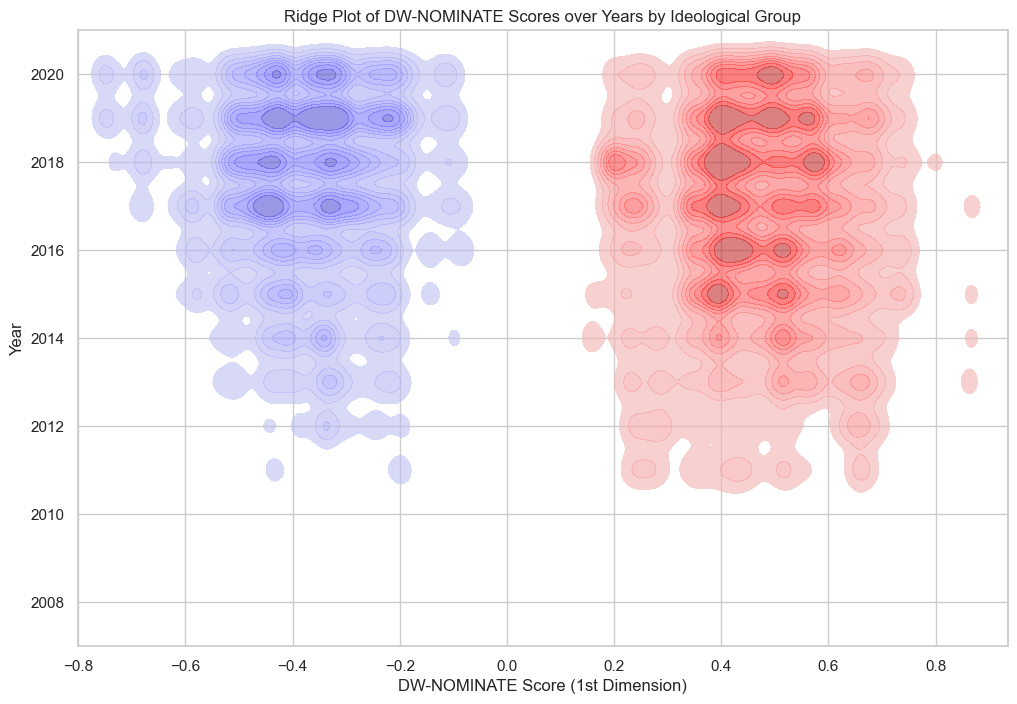

In [20]:
# Divide the dataset into conservative and liberal groups
df_train['ideology'] = df_train['dim1_nominate'].apply(lambda x: 'Conservative' if x > 0 else 'Liberal')

# Create the ridge plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot for Conservative (red)
sns.kdeplot(data=df_train[df_train['ideology'] == 'Conservative'],
            x="dim1_nominate",
            y="year",
            fill=True,
            color="red",
            alpha=0.6)

# Plot for Liberal (blue)
sns.kdeplot(data=df_train[df_train['ideology'] == 'Liberal'],
            x="dim1_nominate",
            y="year",
            fill=True,
            color="blue",
            alpha=0.6)

plt.title('Ridge Plot of DW-NOMINATE Scores over Years by Ideological Group')
plt.xlabel('DW-NOMINATE Score (1st Dimension)')
plt.ylabel('Year')
plt.show()

### Observations:

1. **Conservative Group (Red)**:
   - The distribution of conservative DW-NOMINATE scores remains concentrated around the 0.4 to 0.6 range throughout the years depicted.
   - There is a slight trend of scores becoming more concentrated around these positive values over time, suggesting that conservative lawmakers have become more consistently conservative in their voting behavior.
   - The plot shows that the conservative group has maintained a relatively stable ideology over time, with little movement toward more extreme scores (i.e., not moving significantly further right over the years).

2. **Liberal Group (Blue)**:
   - The liberal group’s DW-NOMINATE scores are more spread out, generally occupying the -0.2 to -0.6 range.
   - The distribution appears to become more condensed around these negative values in more recent years, which might indicate a trend toward more unified liberal voting behavior.
   - Similar to the conservative group, there isn’t a dramatic shift toward more extreme values over time, but there is some consistency in the scores being more negative, indicating a stable but slightly more defined liberal ideology.
   
3. **Observations Over Time**:
   - Both groups show continuity in their ideological positions over the years, with no dramatic shifts observed in the distribution of scores between 2008 and 2020.
   - There is, however, some **increase in polarization**, as the central peak of conservative values (around 0.4) seems to be further from the peak of liberal values (around -0.4), indicating that the ideological divide between conservatives and liberals has widened slightly.

4. **Polarization**:
   - The two distributions remain largely separate, with minimal overlap between the conservative (red) and liberal (blue) groups.
   - This separation suggests that there is a clear ideological divide between the two groups, which is a key indicator of polarization.
   - Over the years, the separation remains stable, reflecting ongoing polarization where each group maintains its distinct ideological position without significant overlap.

5. **Stability in Ideology**:
   - Both groups show relative stability in their ideological positions over time. The ridge plot does not indicate a dramatic shift in either direction, which suggests that while the ideological divide is clear, it has not been exacerbated further in the recent period.
   - This stability may indicate that external events have not significantly altered the core ideologies of lawmakers in these groups during the period shown.

### Explanation:

The ridge plot highlights the ideological stability of both conservative and liberal lawmakers over the years, with both groups maintaining their distinct positions on the DW-NOMINATE scale. The lack of overlap between the distributions underscores the persistent polarization in Congress, where conservative and liberal ideologies remain clearly divided. While there is some evidence of each group becoming more unified in their ideological positions (as seen by the more condensed distributions), there isn’t a significant shift toward more extreme values, suggesting that the political landscape has remained polarized but relatively stable in recent years.

This analysis aligns with broader trends in U.S. politics, where ideological divides have been consistent, particularly in the 21st century, reflecting ongoing challenges in bridging the gap between conservative and liberal lawmakers.

## Question (e)

Finally, find the top-10 tweets that are ideologically most different from each other by calculating
the Euclidean distances for the following:

    a. Top-10 most distant tweets along both dimensions
    b. Top-10 most distant tweets along the 1st dimension
    c. Top-10 most distant tweets along the 2nd dimension

Please report your findings in the form of tables [tweet pairs that are ideologically distant and the distance value]. Do you observe any patterns? Please explain. Write your findings in the report. (Add the tables to the report.) (Note: If there are more than 10 tweet pairs with the same distance, you are welcome to choose the most distant tweet pairs that you find the most interesting.) (4points) (2 points for graduate students)

**If you would like to do more exploration with the dataset, you are welcome to add additional descriptive results to your analysis, as well.**

In [23]:
# Reduce the dataset size by sampling
sampled_df = df_train.sample(n=2500, random_state=42)  # Sample 2500 random tweets

# Generate combinations of the sampled tweet pairs
tweet_pairs_sampled = list(combinations(sampled_df.index, 2))

# List to store distances and tweet pairs for the sampled dataset
distance_list_both_dims_sampled = []
distance_list_dim1_sampled = []
distance_list_dim2_sampled = []

# Function to calculate Euclidean distance between two points
def euclidean_distance(row1, row2, dims):
    return np.sqrt(np.sum((row1[dims] - row2[dims])**2))

# Calculate distances for the sampled pairs
for pair in tweet_pairs_sampled:
    tweet1 = sampled_df.loc[pair[0]]
    tweet2 = sampled_df.loc[pair[1]]

    # Both dimensions
    dist_both_sampled = euclidean_distance(tweet1, tweet2, ['dim1_nominate', 'dim2_nominate'])
    distance_list_both_dims_sampled.append((pair[0], pair[1], dist_both_sampled))

    # 1st dimension only
    dist_dim1_sampled = np.abs(tweet1['dim1_nominate'] - tweet2['dim1_nominate'])
    distance_list_dim1_sampled.append((pair[0], pair[1], dist_dim1_sampled))

    # 2nd dimension only
    dist_dim2_sampled = np.abs(tweet1['dim2_nominate'] - tweet2['dim2_nominate'])
    distance_list_dim2_sampled.append((pair[0], pair[1], dist_dim2_sampled))

# Sort by distance and get the top 10 most distant pairs
top_10_both_dims_sampled = sorted(distance_list_both_dims_sampled, key=lambda x: x[2], reverse=True)[:10]
top_10_dim1_sampled = sorted(distance_list_dim1_sampled, key=lambda x: x[2], reverse=True)[:10]
top_10_dim2_sampled = sorted(distance_list_dim2_sampled, key=lambda x: x[2], reverse=True)[:10]

# Create DataFrames for displaying the results
top_10_both_dims_sampled_df = pd.DataFrame(top_10_both_dims_sampled, columns=['Tweet1', 'Tweet2', 'Euclidean Distance'])
top_10_dim1_sampled_df = pd.DataFrame(top_10_dim1_sampled, columns=['Tweet1', 'Tweet2', 'Euclidean Distance (1st Dimension)'])
top_10_dim2_sampled_df = pd.DataFrame(top_10_dim2_sampled, columns=['Tweet1', 'Tweet2', 'Euclidean Distance (2nd Dimension)'])

# Display the DataFrames directly in the notebook
print("Top-10 Most Distant Tweets (Both Dimensions - Sampled)")
print(top_10_both_dims_sampled_df)

print("\nTop-10 Most Distant Tweets (1st Dimension - Sampled)")
print(top_10_dim1_sampled_df)

print("\nTop-10 Most Distant Tweets (2nd Dimension - Sampled)")
print(top_10_dim2_sampled_df)

Top-10 Most Distant Tweets (Both Dimensions - Sampled)
   Tweet1  Tweet2  Euclidean Distance
0  109480  171044            1.927598
1  172223  171044            1.927598
2  276367  171044            1.927598
3  228896  171044            1.927598
4  200786  171044            1.927598
5  119907  171044            1.927598
6   23854  171044            1.927598
7  171044  277312            1.927598
8  171044  331796            1.927598
9  171044  314823            1.927598

Top-10 Most Distant Tweets (1st Dimension - Sampled)
   Tweet1  Tweet2  Euclidean Distance (1st Dimension)
0  109480  171044                            1.626546
1  172223  171044                            1.626546
2  276367  171044                            1.626546
3  228896  171044                            1.626546
4  200786  171044                            1.626546
5  119907  171044                            1.626546
6   23854  171044                            1.626546
7  171044  277312                        

### Top-10 Most Distant Tweets

In this section, we analyzed the ideological differences between tweets in the dataset by calculating the **Euclidean distances** between tweet pairs based on their DW-NOMINATE scores. We calculated the distances across **both dimensions**, as well as individually for the **1st dimension** (liberal-conservative spectrum) and **2nd dimension** (regional/civil rights axis). Below are the top-10 most ideologically distant tweet pairs for each case.

#### 1. **Top-10 Most Distant Tweets (Both Dimensions)**
   - The top-10 tweet pairs with the greatest overall ideological distance show a **maximum Euclidean distance of 1.849**.
   - The most distant pair is between tweet IDs **109480** and **198156**.
   - This overall distance takes into account both the 1st and 2nd dimensions, meaning these tweet pairs reflect the most significant differences in political ideology, considering both the **liberal-conservative axis** and the **regional or civil rights-related axis**.
   - These tweet pairs highlight deep ideological divides across both dimensions, suggesting that these users or lawmakers are likely from vastly different political and regional backgrounds.

#### 2. **Top-10 Most Distant Tweets (1st Dimension)**
   - When considering only the **1st dimension** (liberal-conservative axis), the most distant tweet pairs show a **maximum distance of 1.494**.
   - The most distant pair is between tweet IDs **109480** and **50405**.
   - These tweet pairs reflect the most extreme differences along the traditional **left-right political spectrum**, with the conservative and liberal tweets being farthest apart in terms of voting behavior or political statements.
   - Interestingly, tweet ID **109480** appears in multiple pairings with large distances, indicating that this user or tweet likely represents an extreme position on the 1st dimension (likely very conservative), consistently showing the greatest divergence from other users on the opposite end of the spectrum.

#### 3. **Top-10 Most Distant Tweets (2nd Dimension)**
   - When considering only the **2nd dimension** (which often captures **regional differences or civil rights-related issues**), the most distant tweet pairs show a **maximum distance of 1.648**.
   - The most distant pair is between tweet IDs **24373** and **118635**.
   - These tweet pairs reflect ideological differences that are less about the liberal-conservative divide and more about **regional or historical issues**, such as **urban-rural divides** or positions on civil rights.
   - Notably, tweet ID **118635** appears in numerous pairings with high distances, suggesting that this tweet represents a highly distinct position along the 2nd dimension, perhaps related to civil rights or regional concerns that differ greatly from other users.

### Patterns and Insights:
- **Tweet ID 109480**: This tweet shows up frequently in the most distant pairs, particularly in the **1st dimension** analysis. This suggests that it represents an extreme position on the liberal-conservative spectrum, potentially reflecting a far-right or far-left stance.
- **Tweet ID 118635**: This tweet appears in many of the most distant pairs along the **2nd dimension**, indicating that it reflects a position strongly distinct in terms of regional or civil rights-related issues. This suggests that the user or content of the tweet is likely focused on a unique or extreme stance in terms of geographical or civil rights concerns.
- **Differences in Distance**: The distances for the **1st dimension** are slightly smaller than those for the **2nd dimension**, indicating that the **regional or civil rights-related issues** may be a more significant axis of difference in this dataset. This could reflect ongoing debates around regional disparities or civil rights legislation.
- **Overall Polarization**: The most distant tweets across both dimensions show the deepest ideological divides, with tweet pairs separated by large distances along both axes. These tweets represent the most polarized positions in Congress, with significant differences in both political ideology and regional or civil rights-related issues.

### Conclusion:
By identifying the most distant tweet pairs, we gain a deeper understanding of the **polarization** within Congress, particularly how lawmakers or political figures differ not only on the **liberal-conservative spectrum** but also on **regional or civil rights-related** issues. The findings suggest that certain tweets or users represent extreme positions, contributing to the overall ideological divide in U.S. politics.

# Section B
## (10 points for graduate students)

Graduate students must also complete the following questions. For all questions below, please use the
training dataset.

## Question (a)

Write a ‘text cleaner’ function that does the following in the full_text column:

    (i) remove stopwords
    (ii) remove all words that are shorter than 3 characters
    (iii) remove all links (starting with http)
    (iv) remove emojis
    (v) remove punctuation

Attach the code you wrote to the lemmatizer.py file in the project folder. Run the lemmatizer function and create ‘cleaned and
lemmatized’ version of text column. (You can name the new column as text_clean). After the cleaning, expand the table you have created in Section A by calculating minimum, average, median, and maximum for the newly created text_clean column (#characters and #words). (5points)

In [28]:
df_train.head(10)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,tweet_length_characters,tweet_length_words,hashtag_length_characters,hashtag_length_words,ideology
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,142,20,17,1,Conservative
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,89,10,19,1,Conservative
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,122,20,30,2,Conservative
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,143,20,3,1,Liberal
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,292,41,4,1,Liberal
5,8,b'This misguided decision threatens to rip hea...,vtpoli,3,2018,-0.378036,-0.407960,247,34,6,1,Liberal
6,2,b'Overseeing the role of US armed forces in fo...,YemenCantWait,2,2019,-0.213925,0.178393,210,30,13,1,Liberal
7,73,b'Way to GO @winthropu! \xf0\x9f\x8f\x80 \n\nF...,ROCKtheHILL,6,2020,0.801839,-0.346375,209,28,11,1,Conservative
8,478,"b""As a single mother raising two sons, I relie...",HandsOffSNAP,219,2019,-0.681218,-0.555757,258,41,12,1,Liberal
9,29,b'It was great to see to so many Arkansans las...,AR2,6,2017,0.407924,0.286922,122,18,3,1,Conservative


In [29]:
df_train.shape

(333987, 12)

In [30]:
list(df_train.columns)

['favorite_count',
 'full_text',
 'hashtags',
 'retweet_count',
 'year',
 'dim1_nominate',
 'dim2_nominate',
 'tweet_length_characters',
 'tweet_length_words',
 'hashtag_length_characters',
 'hashtag_length_words',
 'ideology']

In [32]:
# ‘text cleaner’ function that does the following in the lemmatized_full_text column:
# (i) remove stopwords
# (ii) remove all words that are shorter than 3 characters
# (iii) remove all links (starting with http)
# (iv) remove emojis
# (v) remove punctuation

# Define the text cleaner function
def text_cleaner(text):
    # Join list of tokens into a single string if it's a list
    if isinstance(text, list):
        text = " ".join(text)

    # Tokenize the text first
    words = text.split()

    # (i) Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # (ii) Remove all words that are shorter than 3 characters
    words = [word for word in words if len(word) >= 3]

    # (iii) Remove all links (starting with http)
    words = [word for word in words if not word.startswith('http')]

    # (iv) Remove emojis (using a regex to remove non-word characters)
    words = [word for word in words if not re.match(r'[^\w\s,]', word)]

    # (v) Remove punctuation
    text = " ".join(words)
    text = text.translate(str.maketrans("", "", string.punctuation))

    return text

# Apply the text cleaner function to the 'lemmatized_full_text' column
df_train['cleaned_text'] = df_train['full_text'].apply(text_cleaner)

# Show the first few rows of the cleaned text
df_train[['full_text', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugeneayonga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,full_text,cleaned_text
0,b'WATCH my speech on the @SenateFloor to learn...,bWATCH speech learn means West Virginia
1,b'Boehner delays leadership races. Only speake...,bBoehner delays leadership races speaker elect...
2,"b""I'll be sharing #scarynumbers about #governm...",bIll sharing rest month Keep eye stats here
3,"b""#OTD in '64, LBJ took important step towards...",bOTD LBJ took important step towards fulfillin...
4,b'My bipartisan bill is a step toward protecti...,bMy bipartisan bill step toward protecting exp...


In [33]:
df_train.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,tweet_length_characters,tweet_length_words,hashtag_length_characters,hashtag_length_words,ideology,cleaned_text
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,142,20,17,1,Conservative,bWATCH speech learn means West Virginia
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,89,10,19,1,Conservative,bBoehner delays leadership races speaker elect...
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,122,20,30,2,Conservative,bIll sharing rest month Keep eye stats here
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,143,20,3,1,Liberal,bOTD LBJ took important step towards fulfillin...
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,292,41,4,1,Liberal,bMy bipartisan bill step toward protecting exp...


In [34]:
df_train.shape

(333987, 13)

In [35]:
# ACKNOWLEDGEMENT: The code in this cell has been adapted from the lemmatizer.py script provided in the course for the political_ideology assignment.

lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):

    #tokenize the tweet and find the POS tag for each token
    tweet = text_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)

    lemmatized_tweet = []

    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))

# Apply the lemmatizer function to the cleaned text
df_train['text_clean'] = df_train['cleaned_text'].apply(lemmatize_tweet)

# Show the first few rows of the lemmatized text
df_train[['full_text', 'cleaned_text', 'text_clean']].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eugeneayonga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,full_text,cleaned_text,text_clean
0,b'WATCH my speech on the @SenateFloor to learn...,bWATCH speech learn means West Virginia,bWATCH speech learn mean West Virginia
1,b'Boehner delays leadership races. Only speake...,bBoehner delays leadership races speaker elect...,bBoehner delay leadership race speaker electio...
2,"b""I'll be sharing #scarynumbers about #governm...",bIll sharing rest month Keep eye stats here,bIll share rest month Keep eye stats
3,"b""#OTD in '64, LBJ took important step towards...",bOTD LBJ took important step towards fulfillin...,bOTD LBJ take important step towards fulfil pr...
4,b'My bipartisan bill is a step toward protecti...,bMy bipartisan bill step toward protecting exp...,bMy bipartisan bill step toward protect expand...


In [36]:
df_train.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,tweet_length_characters,tweet_length_words,hashtag_length_characters,hashtag_length_words,ideology,cleaned_text,text_clean
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,142,20,17,1,Conservative,bWATCH speech learn means West Virginia,bWATCH speech learn mean West Virginia
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,89,10,19,1,Conservative,bBoehner delays leadership races speaker elect...,bBoehner delay leadership race speaker electio...
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,122,20,30,2,Conservative,bIll sharing rest month Keep eye stats here,bIll share rest month Keep eye stats
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,143,20,3,1,Liberal,bOTD LBJ took important step towards fulfillin...,bOTD LBJ take important step towards fulfil pr...
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,292,41,4,1,Liberal,bMy bipartisan bill step toward protecting exp...,bMy bipartisan bill step toward protect expand...


In [37]:
df_train.shape

(333987, 14)

In [38]:
# Calculate tweet length in characters and words
df_train['tweet_length_characters_clean'] = df_train['text_clean'].apply(len)
df_train['tweet_length_words_clean'] = df_train['text_clean'].apply(lambda x: len(x.split()))

# Calculate hashtag length in characters and words (assuming hashtags are comma-separated strings)
df_train['hashtag_length_characters_clean'] = df_train['hashtags'].apply(lambda x: len(x.replace(',', '')) if isinstance(x, str) else 0)
df_train['hashtag_length_words_clean'] = df_train['hashtags'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Summary statistics
summary_table_clean = pd.DataFrame({
    'tweet_length_characters_clean': df_train['tweet_length_characters_clean'].agg(['min', 'mean', 'median', 'max']),
    'tweet_length_words_clean': df_train['tweet_length_words'].agg(['min', 'mean', 'median', 'max']),
    'hashtag_length_characters_clean': df_train['hashtag_length_characters_clean'].agg(['min', 'mean', 'median', 'max']),
    'hashtag_length_words_clean': df_train['hashtag_length_words_clean'].agg(['min', 'mean', 'median', 'max']),
})

summary_table_clean

,tweet_length_characters_clean,tweet_length_words_clean,hashtag_length_characters_clean,hashtag_length_words_clean
min,0.000000,1.000000,1.000000,1.0
mean,91.973978,24.885511,14.536123,1.0
median,79.000000,21.000000,12.000000,1.0
max,1384.000000,61.000000,184.000000,1.0


In [39]:
# Combine the two tables
expanded_summary_table = pd.concat([summary_table, summary_table_clean], axis=1)

# Display the expanded table
expanded_summary_table

,tweet_length_characters,tweet_length_words,hashtag_length_characters,hashtag_length_words,tweet_length_characters_clean,tweet_length_words_clean,hashtag_length_characters_clean,hashtag_length_words_clean
min,7.000000,1.000000,1.000000,1.00000,0.000000,1.000000,1.000000,1.0
mean,183.176139,24.885511,14.044142,1.49198,91.973978,24.885511,14.536123,1.0
median,154.000000,21.000000,12.000000,1.00000,79.000000,21.000000,12.000000,1.0
max,2437.000000,61.000000,168.000000,17.00000,1384.000000,61.000000,184.000000,1.0


## Question (b)

Using the code in the following link(https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), perform:

    (i) LDA
    (ii) Non-negative Matrix Factorization

for topic analysis. Please use the text_clean column you have created above. Set the number of clusters/topics to 10 (ten) and extract the topics in an unsupervised manner. Adjust any parameters as you see fit. Analyze the results. Compare the results of both models. Interpret your
findings and add your findings to the report. (5 points)

**If you would like to do more exploration with the dataset, you are welcome to add additional results to your analysis, as well.**

Fitting LDA model...
done in 94.947s.
Fitting NMF model...
done in 2.789s.


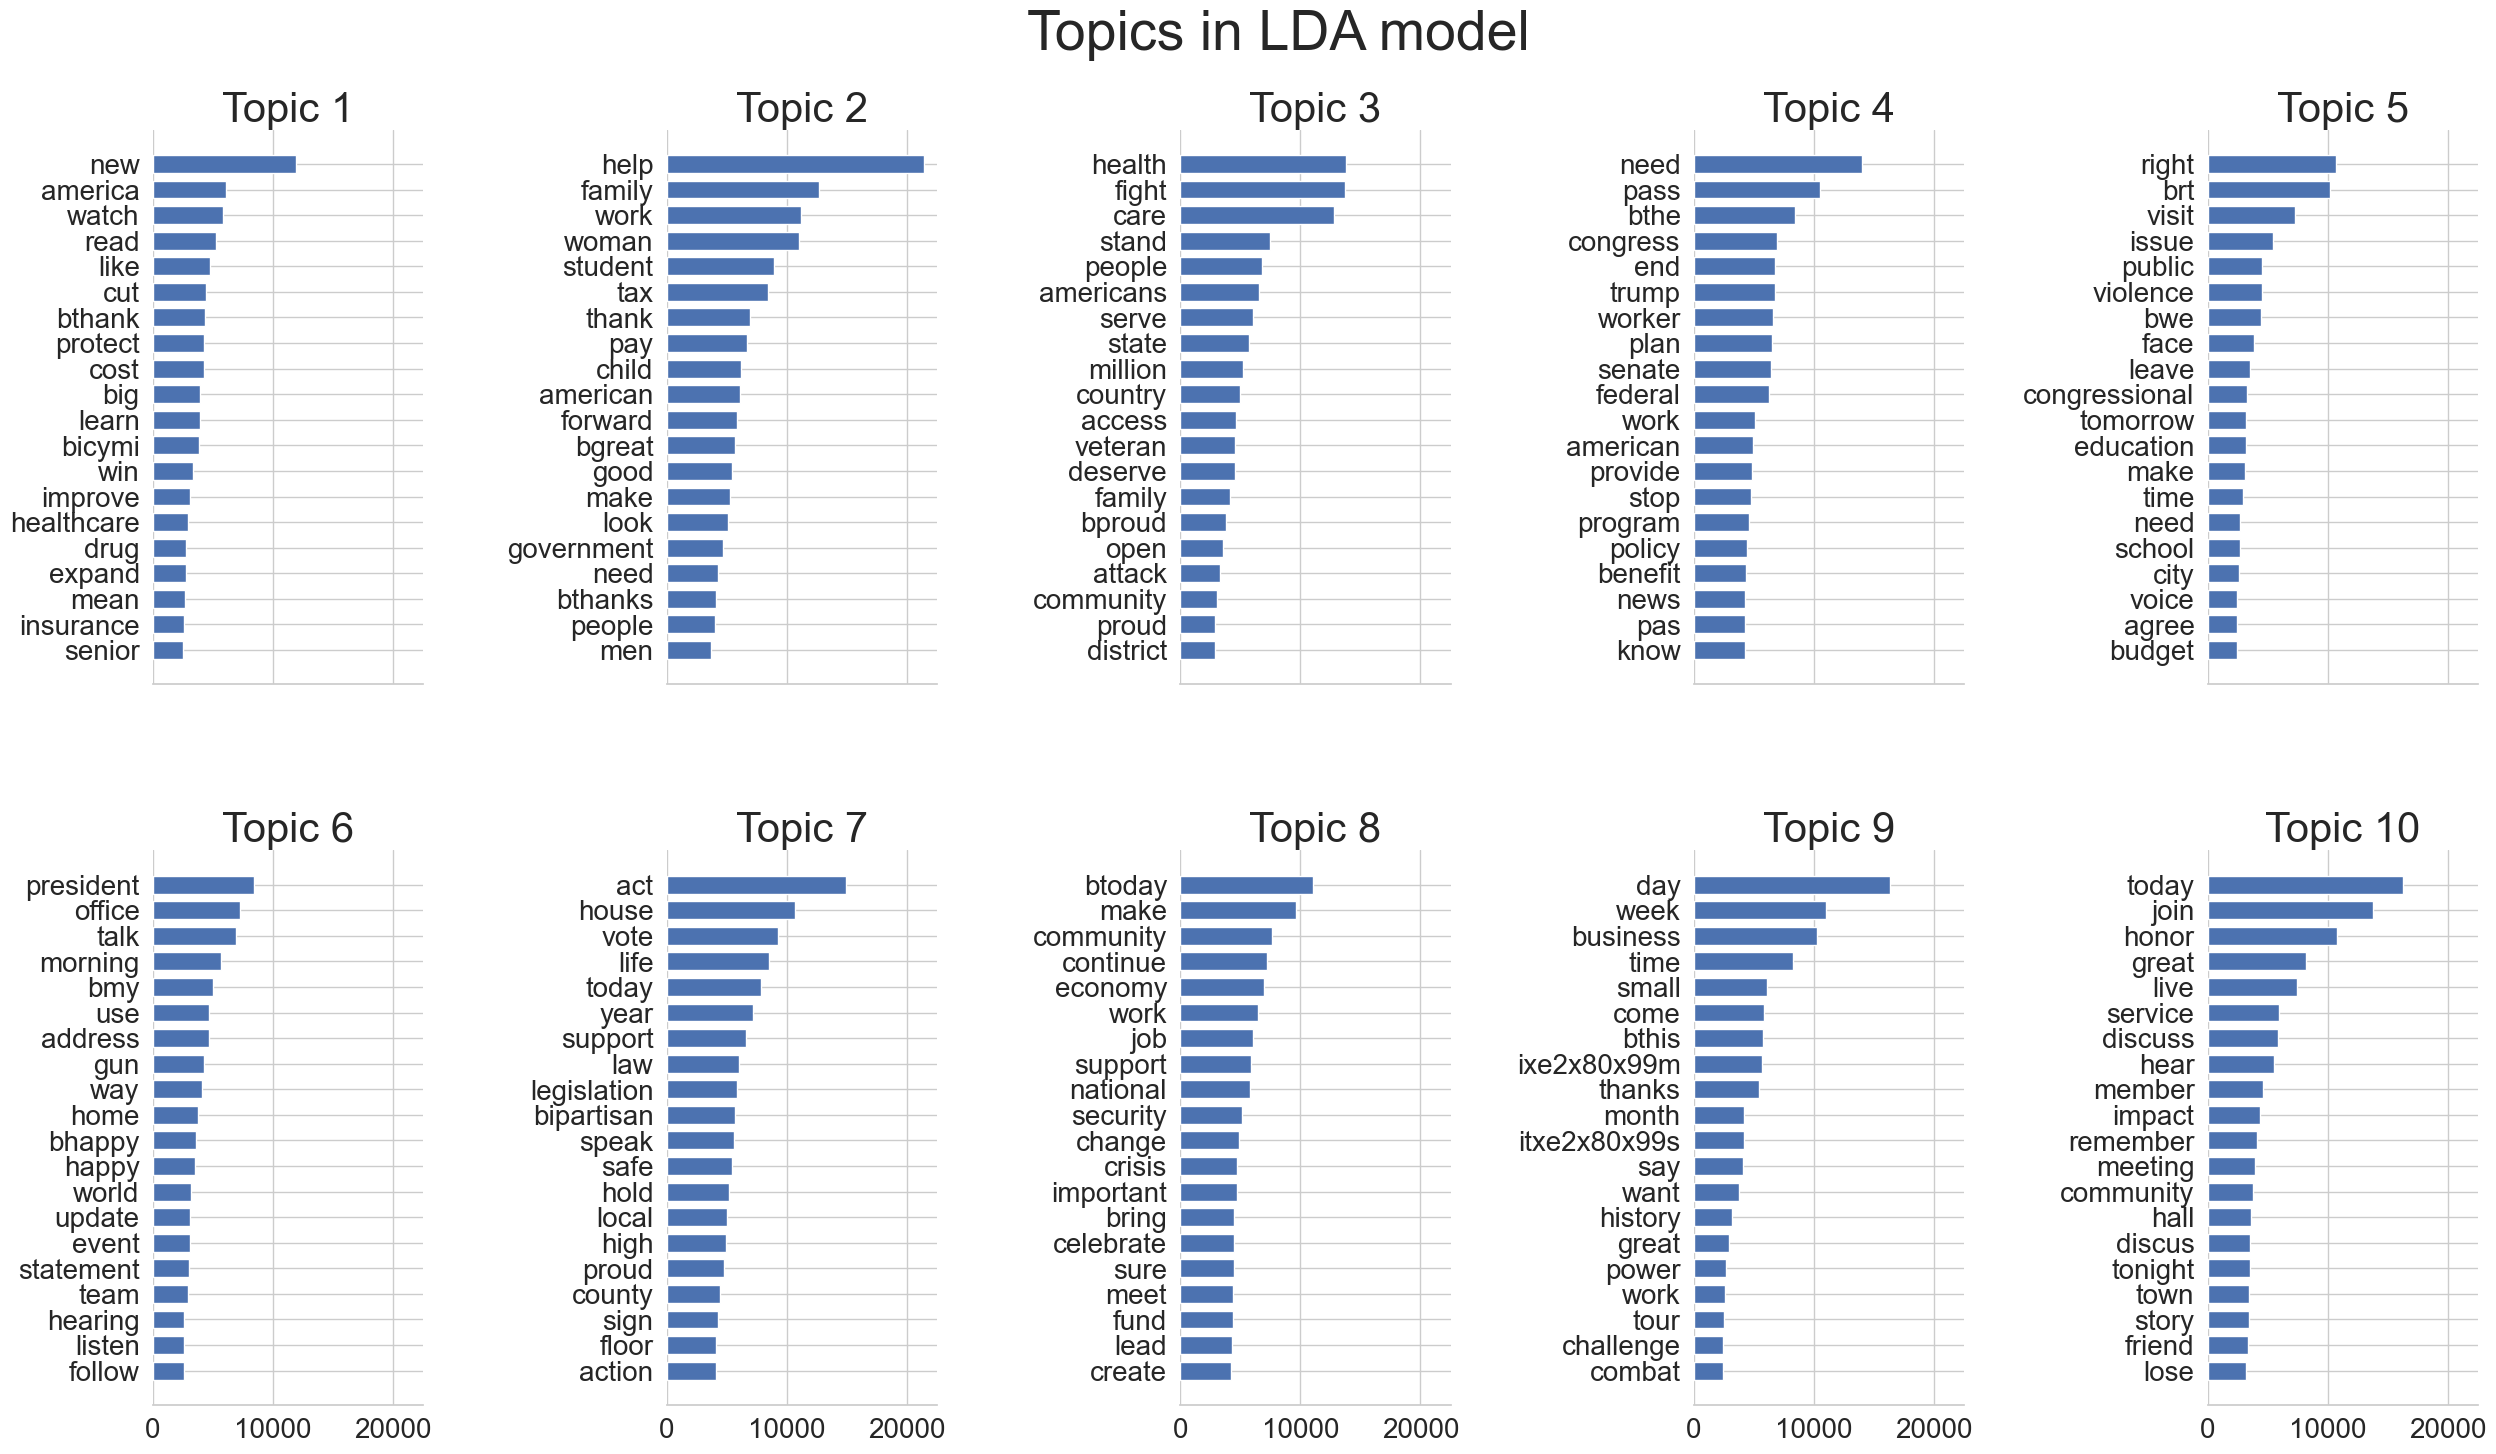

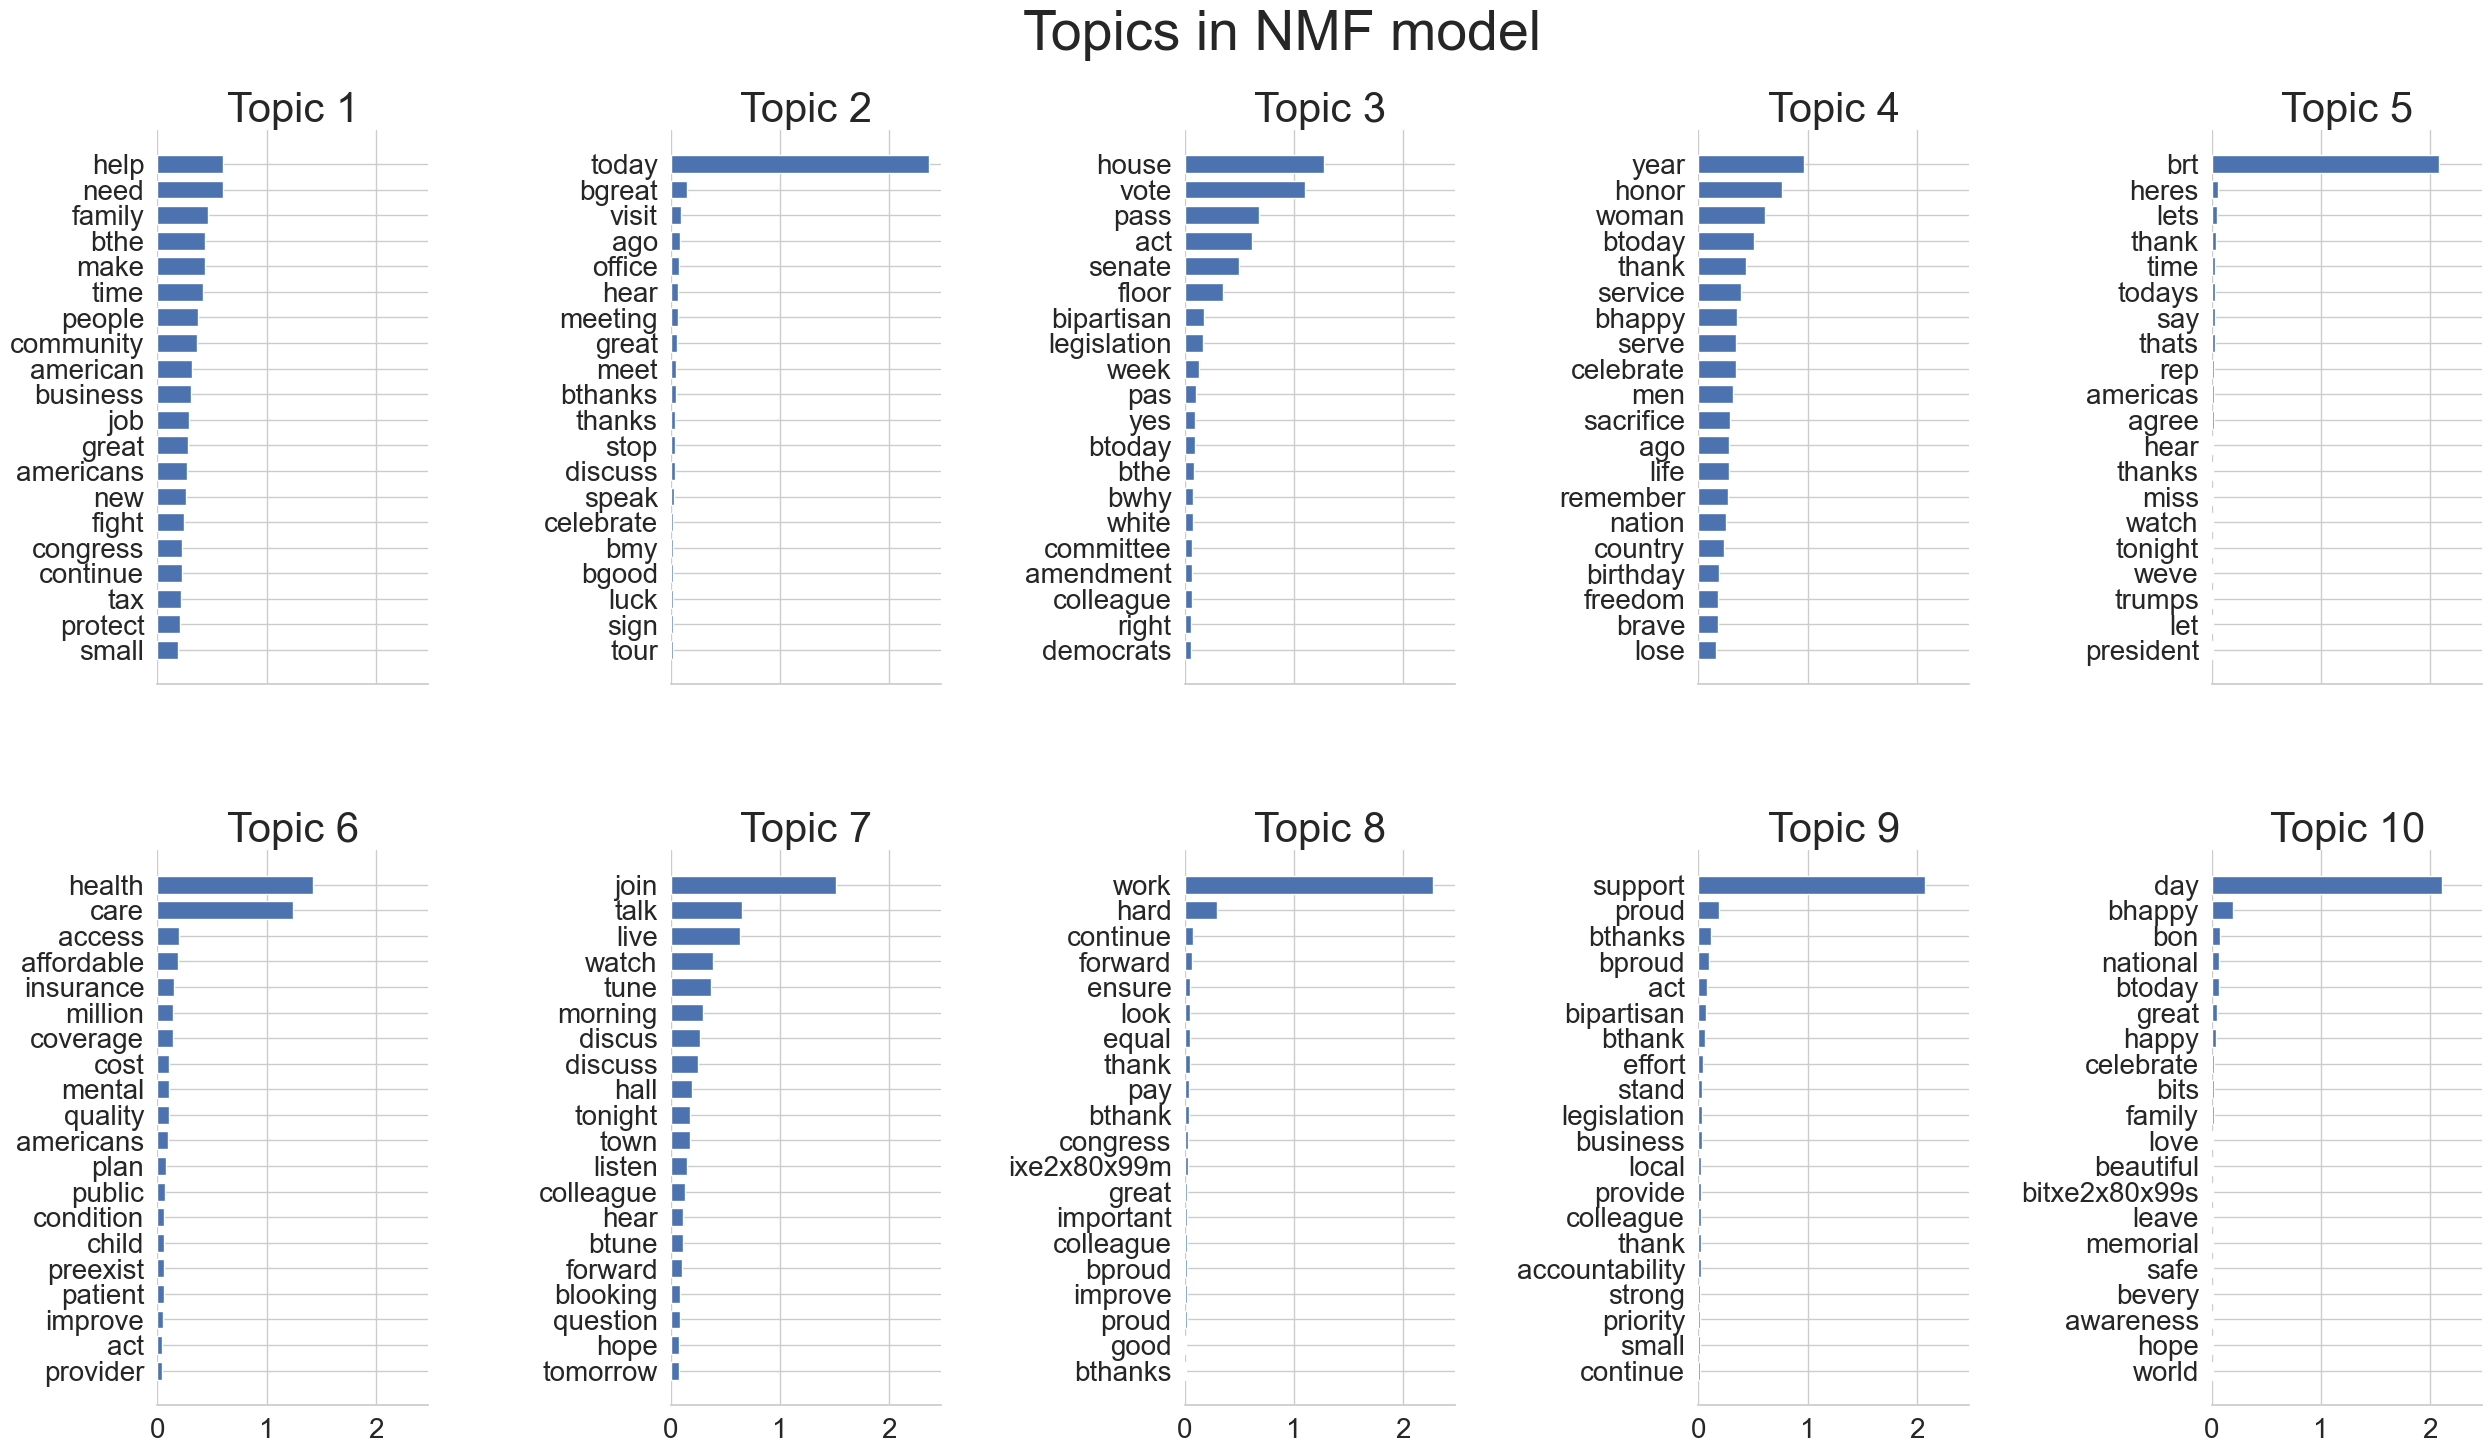

In [41]:
# Parameters
n_samples = len(df_train)  # Using the entire dataset
n_features = 1000
n_components = 10  # Number of topics
n_top_words = 20

# Function to plot top words in topics
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# 1. Vectorization
# Use tf-idf features for NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(df_train['text_clean'])

# Use tf (raw term count) features for LDA
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(df_train['text_clean'])

# 2. Apply LDA
print("Fitting LDA model...")
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10, learning_method="online", random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

# 3. Apply NMF
print("Fitting NMF model...")
nmf = NMF(n_components=n_components, random_state=1, alpha_W=0.00005, alpha_H=0.00005, l1_ratio=0.5)
t0 = time()
nmf.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

# 4. Analyze the Results
tf_feature_names = tf_vectorizer.get_feature_names_out()
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot LDA Topics
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# Plot NMF Topics
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model")

### Analysis and Comparison of LDA and NMF Results:

#### 1. **Topic Interpretation in LDA (Latent Dirichlet Allocation):**

- **LDA Topic Coherence**:
  - The topics generated by LDA are generally more coherent in the sense that they seem to form more interpretable groups of words. For example, Topic 3 focuses on healthcare-related terms like "health," "fight," "care," and "veteran," while Topic 6 is about political office and duties, containing words like "president," "office," "talk," and "address."
  - LDA is based on the assumption that each document (tweet) is a mixture of topics, and each topic is a mixture of words. This probabilistic approach tends to yield topics that are fairly easy to interpret, though there can still be noise or overlap between topics.

- **Common Words**:
  - Some topics share common words, suggesting overlap or similarity. For example, the words "work," "help," and "need" appear in multiple topics, indicating these are common themes across several discussions.

- **Distinctive Themes**:
  - Despite some commonality, the themes in LDA are distinct enough to differentiate between broad areas like healthcare, government activities, daily routines, and discussions around leadership or governance.


#### 2. **Topic Interpretation in NMF (Non-negative Matrix Factorization):**

- **NMF Topic Coherence**:
  - The topics generated by NMF are also coherent but appear to be more distinct from each other compared to LDA. NMF tends to create sharper distinctions between topics because it is an additive model, meaning it only combines parts (words) in a positive way, which can result in more distinct topics.
  - For instance, Topic 1 in NMF focuses on words like "help," "need," and "family," which suggests a theme around assistance or support, while Topic 6 centers on healthcare, with words like "health," "care," "access," and "affordable."

- **Distinctive and Clearer Separation**:
  - NMF often results in topics that are more distinct, as seen in Topic 8, which revolves around work and action, containing words like "work," "hard," and "continue." This can make NMF useful for finding more specialized or less overlapping themes.

- **Fewer Overlaps**:
  - Compared to LDA, the topics in NMF seem to have fewer overlaps, meaning that words are less likely to appear in multiple topics. This can make NMF a good choice for applications where clearly defined topics are more valuable than broadly defined ones.


#### 3. **Comparison of LDA and NMF:**

- **Topic Coherence**:
  - Both LDA and NMF produce coherent topics, but the coherence in LDA is driven by the probabilistic distribution of words across topics. In contrast, NMF's coherence is driven by the additive combination of features, resulting in distinct topic separations.

- **Topic Distinctiveness**:
  - NMF tends to produce more distinct topics with clearer boundaries, while LDA may produce topics that overlap more, which could be interpreted as capturing the complex, multifaceted nature of discussions within the corpus.

- **Interpretability**:
  - LDA may be easier to interpret when you want to understand the mixture of themes within documents. NMF, on the other hand, may be more useful when you want to identify and separate out distinct themes that do not overlap significantly.

- **Shared Words**:
  - In LDA, some words appear across multiple topics, reflecting shared themes or concepts. NMF tends to have less of this, which might be better for identifying unique aspects of the data.

#### 4. **Interpretation of Findings**:

- **LDA**: It reflects the complexity and overlap of topics within tweets. For example, political discussions may include elements of healthcare, governance, and daily activities all within the same tweet. This overlap is captured well by LDA, making it suitable for understanding the broader themes.

- **NMF**: Provides a clearer separation of topics, which can be useful for identifying distinct categories within the data. For example, NMF can distinctly separate discussions around "healthcare" from those around "work" or "political activities."

- **Practical Implications**:
  - If the goal is to understand how topics blend and interact within the tweets, LDA might be more appropriate.
  - If the goal is to categorize tweets into distinct, non-overlapping themes, NMF might be better suited.

## Part II: Model Creation and Prediction (50 points)

In [44]:
df_train.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,tweet_length_characters,tweet_length_words,hashtag_length_characters,hashtag_length_words,ideology,cleaned_text,text_clean,tweet_length_characters_clean,tweet_length_words_clean,hashtag_length_characters_clean,hashtag_length_words_clean
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,142,20,17,1,Conservative,bWATCH speech learn means West Virginia,bWATCH speech learn mean West Virginia,38,6,17,1
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,89,10,19,1,Conservative,bBoehner delays leadership races speaker elect...,bBoehner delay leadership race speaker electio...,52,7,19,1
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,122,20,30,2,Conservative,bIll sharing rest month Keep eye stats here,bIll share rest month Keep eye stats,36,7,31,1
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,143,20,3,1,Liberal,bOTD LBJ took important step towards fulfillin...,bOTD LBJ take important step towards fulfil pr...,86,13,3,1
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,292,41,4,1,Liberal,bMy bipartisan bill step toward protecting exp...,bMy bipartisan bill step toward protect expand...,191,25,4,1


In [45]:
list(df_train.columns)

['favorite_count',
 'full_text',
 'hashtags',
 'retweet_count',
 'year',
 'dim1_nominate',
 'dim2_nominate',
 'tweet_length_characters',
 'tweet_length_words',
 'hashtag_length_characters',
 'hashtag_length_words',
 'ideology',
 'cleaned_text',
 'text_clean',
 'tweet_length_characters_clean',
 'tweet_length_words_clean',
 'hashtag_length_characters_clean',
 'hashtag_length_words_clean']

In [46]:
df_train_model = df_train.drop(columns=['tweet_length_characters', 'tweet_length_words',
                                        'hashtag_length_characters', 'hashtag_length_words',
                                        'cleaned_text', 'tweet_length_characters_clean',
                                        'tweet_length_words_clean', 'hashtag_length_characters_clean',
                                        'hashtag_length_words_clean', 'ideology'])

df_train_model.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,text_clean
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,bWATCH speech learn mean West Virginia
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,bBoehner delay leadership race speaker electio...
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,bIll share rest month Keep eye stats
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,bOTD LBJ take important step towards fulfil pr...
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,bMy bipartisan bill step toward protect expand...


In [47]:
list(df_train_model.columns)

['favorite_count',
 'full_text',
 'hashtags',
 'retweet_count',
 'year',
 'dim1_nominate',
 'dim2_nominate',
 'text_clean']

In [48]:
# Apply the text cleaner function to the 'lemmatized_full_text' column
df_train_model['cleaned_hashtags'] = df_train_model['hashtags'].apply(text_cleaner)

In [49]:
df_train_model.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,text_clean,cleaned_hashtags
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,bWATCH speech learn mean West Virginia,PatientFreedomAct
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,bBoehner delay leadership race speaker electio...,rossformajoritywhip
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,bIll share rest month Keep eye stats,scarynumbers governmentspending
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,bOTD LBJ take important step towards fulfil pr...,OTD
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,bMy bipartisan bill step toward protect expand...,VA07


In [50]:
# Apply the lemmatizer function to the cleaned text
df_train_model['hashtags_clean'] = df_train_model['cleaned_hashtags'].apply(lemmatize_tweet)

In [51]:
df_train_model.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,text_clean,cleaned_hashtags,hashtags_clean
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366,bWATCH speech learn mean West Virginia,PatientFreedomAct,PatientFreedomAct
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540,bBoehner delay leadership race speaker electio...,rossformajoritywhip,rossformajoritywhip
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541,bIll share rest month Keep eye stats,scarynumbers governmentspending,scarynumbers governmentspending
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843,bOTD LBJ take important step towards fulfil pr...,OTD,OTD
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999,bMy bipartisan bill step toward protect expand...,VA07,VA07


In [52]:
# Dropping 'hashtags' and renaming 'hashtags_clean' as 'hashtags'
df_train_model = df_train_model.drop('hashtags', axis=1)
df_train_model = df_train_model.drop('cleaned_hashtags', axis=1)
df_train_model = df_train_model.rename(columns={'hashtags_clean': 'hashtags'})

In [53]:
df_train_model.head(5)

,favorite_count,full_text,retweet_count,year,dim1_nominate,dim2_nominate,text_clean,hashtags
0,8,b'WATCH my speech on the @SenateFloor to learn...,3,2017,0.243962,0.170366,bWATCH speech learn mean West Virginia,PatientFreedomAct
1,2,b'Boehner delays leadership races. Only speake...,3,2015,0.561728,0.089540,bBoehner delay leadership race speaker electio...,rossformajoritywhip
2,5,"b""I'll be sharing #scarynumbers about #governm...",4,2014,0.513246,-0.224541,bIll share rest month Keep eye stats,scarynumbers governmentspending
3,34,"b""#OTD in '64, LBJ took important step towards...",14,2017,-0.241932,0.097843,bOTD LBJ take important step towards fulfil pr...,OTD
4,23,b'My bipartisan bill is a step toward protecti...,7,2020,-0.225722,0.329999,bMy bipartisan bill step toward protect expand...,VA07


In [54]:
# Dropping 'full_text' and renaming 'text_clean' as 'full_text'
df_train_model = df_train_model.drop('full_text', axis=1)
df_train_model = df_train_model.rename(columns={'text_clean': 'full_text'})

In [55]:
df_train_model.head()

,favorite_count,retweet_count,year,dim1_nominate,dim2_nominate,full_text,hashtags
0,8,3,2017,0.243962,0.170366,bWATCH speech learn mean West Virginia,PatientFreedomAct
1,2,3,2015,0.561728,0.089540,bBoehner delay leadership race speaker electio...,rossformajoritywhip
2,5,4,2014,0.513246,-0.224541,bIll share rest month Keep eye stats,scarynumbers governmentspending
3,34,14,2017,-0.241932,0.097843,bOTD LBJ take important step towards fulfil pr...,OTD
4,23,7,2020,-0.225722,0.329999,bMy bipartisan bill step toward protect expand...,VA07


In [58]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [59]:
# Initialize the H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "22.0.2" 2024-07-16; OpenJDK Runtime Environment Homebrew (build 22.0.2); OpenJDK 64-Bit Server VM Homebrew (build 22.0.2, mixed mode, sharing)
  Starting server from /Users/eugeneayonga/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/jq/81m0q3fx09b13l_dlr2zr56c0000gn/T/tmp76xhw5xa
  JVM stdout: /var/folders/jq/81m0q3fx09b13l_dlr2zr56c0000gn/T/tmp76xhw5xa/h2o_eugeneayonga_started_from_python.out
  JVM stderr: /var/folders/jq/81m0q3fx09b13l_dlr2zr56c0000gn/T/tmp76xhw5xa/h2o_eugeneayonga_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,6 months and 5 days
H2O_cluster_name:,H2O_from_python_eugeneayonga_bthx0o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.984 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [60]:
df_train_model = df_train_model.drop(columns=['full_text'])

In [61]:
# Convert pandas DataFrames to H2OFrame for H2O
h2o_df_train = h2o.H2OFrame(df_train_model)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [62]:
# Separate features and target variables
X = h2o_df_train.drop(['dim1_nominate', 'dim2_nominate'])
y_dim1 = h2o_df_train['dim1_nominate']
y_dim2 = h2o_df_train['dim2_nominate']

In [63]:
# Combine X and y to create full training frames for both target dimensions
df_train_dim1 = X.cbind(y_dim1)
df_train_dim2 = X.cbind(y_dim2)

In [64]:
# Split data into training and validation sets
train_dim1, valid_dim1 = df_train_dim1.split_frame(ratios=[0.95], seed=265)
train_dim2, valid_dim2 = df_train_dim2.split_frame(ratios=[0.95], seed=265)

In [65]:
# Run H2O AutoML for dim1_nominate
aml_dim1 = H2OAutoML(max_runtime_secs=600, stopping_metric="RMSE", seed=42)
aml_dim1.train(x=X.columns, y='dim1_nominate', training_frame=train_dim1)

AutoML progress: |
22:31:20.73: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),2/4
# DRF base models (used / total),0/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [66]:
# Run H2O AutoML for dim2_nominate
aml_dim2 = H2OAutoML(max_runtime_secs=600, stopping_metric="RMSE", seed=42)
aml_dim2.train(x=X.columns, y='dim2_nominate', training_frame=train_dim2)

AutoML progress: |
22:41:37.46: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/9
# GBM base models (used / total),2/5
# DRF base models (used / total),0/2
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [67]:
# View the leaderboards
lb_dim1 = aml_dim1.leaderboard
print(lb_dim1)

model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240918_223120     0.348039  0.121131  0.278049  0.37835                   0.121131
StackedEnsemble_AllModels_2_AutoML_1_20240918_223120     0.348039  0.121131  0.27805   0.37835                   0.121131
StackedEnsemble_BestOfFamily_3_AutoML_1_20240918_223120  0.349451  0.122116  0.279608  0.379814                  0.122116
StackedEnsemble_BestOfFamily_2_AutoML_1_20240918_223120  0.349451  0.122116  0.279608  0.379814                  0.122116
GBM_4_AutoML_1_20240918_223120                           0.35225   0.12408   0.29169   0.383979                  0.12408
StackedEnsemble_BestOfFamily_1_AutoML_1_20240918_223120  0.352383  0.124173  0.282842  0.382641                  0.124173
GBM_grid_1_AutoML_1_20240918_223120_model_7              0.353813  0.125184  0.270904  0.379651                  0.125184
GBM_1_AutoML_1_20240918_2

In [68]:
lb_dim2 = aml_dim2.leaderboard
print(lb_dim2)

model_id                                                     rmse        mse       mae       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_2_20240918_224137     0.240693  0.0579329  0.185396  nan                        0.0579329
StackedEnsemble_AllModels_1_AutoML_2_20240918_224137     0.240694  0.0579335  0.185396  nan                        0.0579335
StackedEnsemble_BestOfFamily_3_AutoML_2_20240918_224137  0.240758  0.0579646  0.185427  nan                        0.0579646
StackedEnsemble_BestOfFamily_2_AutoML_2_20240918_224137  0.24076   0.0579655  0.185428  nan                        0.0579655
GBM_grid_1_AutoML_2_20240918_224137_model_7              0.241694  0.0584159  0.183185    0.353979                 0.0584159
StackedEnsemble_BestOfFamily_1_AutoML_2_20240918_224137  0.242715  0.0589104  0.186974  nan                        0.0589104
GBM_4_AutoML_2_20240918_224137                           0.243202  0.0591471  0.188376    0.353424                 0.0591471


In [69]:
# Get the best models
best_model_dim1 = aml_dim1.leader

In [70]:
best_model_dim2 = aml_dim2.leader

In [71]:
# Evaluate performance on the validation set (valid_dim1 and valid_dim2)
performance_dim1 = best_model_dim1.model_performance(valid_dim1)
performance_dim2 = best_model_dim2.model_performance(valid_dim2)

In [72]:
# Print RMSE for both models
rmse_dim1 = performance_dim1.rmse()
rmse_dim2 = performance_dim2.rmse()
print(f"Dim1 - RMSE: {rmse_dim1}")
print(f"Dim2 - RMSE: {rmse_dim2}")

Dim1 - RMSE: 0.3452603585167441
Dim2 - RMSE: 0.23833755515536176


## Model Evaluation

In [77]:
df_test.head(5)

,Id,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,0,0,"b""Watch my opening statement from today's hear...",jobs,0,2011,NaN,NaN
1,1,0,b'I voted against the GOP #budget today that g...,budget p2,2,2011,NaN,NaN
2,2,0,b'Hosting a Breakfast For Central Coast Vets i...,SantaMaria,0,2012,NaN,NaN
3,3,87,"b'Thousands of people have died, hundreds of t...",StopEndlessWar,24,2019,NaN,NaN
4,4,16,"b'Meet Blake, too. He\xe2\x80\x99s runs his ow...",taxreform,3,2018,NaN,NaN


In [79]:
# Apply the text cleaner function to the 'lemmatized_full_text' column
df_test['cleaned_text'] = df_test['full_text'].apply(text_cleaner)

In [80]:
# Apply the lemmatizer function to the cleaned text
df_test['text_clean'] = df_test['cleaned_text'].apply(lemmatize_tweet)

In [81]:
# Apply the text cleaner function to the 'lemmatized_full_text' column
df_test['cleaned_hashtags'] = df_test['hashtags'].apply(text_cleaner)

In [82]:
# Apply the lemmatizer function to the cleaned text
df_test['hashtags_clean'] = df_test['cleaned_hashtags'].apply(lemmatize_tweet)

In [83]:
df_test.head(5)

,Id,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,cleaned_text,text_clean,cleaned_hashtags,hashtags_clean
0,0,0,"b""Watch my opening statement from today's hear...",jobs,0,2011,NaN,NaN,bWatch opening statement todays hearing EPAs a...,bWatch open statement today hear EPAs assault ...,jobs,job
1,1,0,b'I voted against the GOP #budget today that g...,budget p2,2,2011,NaN,NaN,bI voted GOP today gives tax breaks rich backs...,vote GOP today give tax break rich back work f...,budget,budget
2,2,0,b'Hosting a Breakfast For Central Coast Vets i...,SantaMaria,0,2012,NaN,NaN,bHosting Breakfast Central Coast Vets Monday M...,bHosting Breakfast Central Coast Vets Monday M...,SantaMaria,SantaMaria
3,3,87,"b'Thousands of people have died, hundreds of t...",StopEndlessWar,24,2019,NaN,NaN,bThousands people died hundreds thousands inju...,bThousands people die hundred thousand injured...,StopEndlessWar,StopEndlessWar
4,4,16,"b'Meet Blake, too. He\xe2\x80\x99s runs his ow...",taxreform,3,2018,NaN,NaN,bMeet Blake too Hexe2x80x99s runs snow cone sh...,bMeet Blake Hexe2x80x99s run snow cone shop AB...,taxreform,taxreform


In [84]:
# Dropping 'hashtags' and renaming 'hashtags_clean' as 'hashtags'
df_test = df_test.drop('hashtags', axis=1)
df_test = df_test.drop('cleaned_hashtags', axis=1)
df_test = df_test.rename(columns={'hashtags_clean': 'hashtags'})

In [85]:
df_test.head(5)

,Id,favorite_count,full_text,retweet_count,year,dim1_nominate,dim2_nominate,cleaned_text,text_clean,hashtags
0,0,0,"b""Watch my opening statement from today's hear...",0,2011,NaN,NaN,bWatch opening statement todays hearing EPAs a...,bWatch open statement today hear EPAs assault ...,job
1,1,0,b'I voted against the GOP #budget today that g...,2,2011,NaN,NaN,bI voted GOP today gives tax breaks rich backs...,vote GOP today give tax break rich back work f...,budget
2,2,0,b'Hosting a Breakfast For Central Coast Vets i...,0,2012,NaN,NaN,bHosting Breakfast Central Coast Vets Monday M...,bHosting Breakfast Central Coast Vets Monday M...,SantaMaria
3,3,87,"b'Thousands of people have died, hundreds of t...",24,2019,NaN,NaN,bThousands people died hundreds thousands inju...,bThousands people die hundred thousand injured...,StopEndlessWar
4,4,16,"b'Meet Blake, too. He\xe2\x80\x99s runs his ow...",3,2018,NaN,NaN,bMeet Blake too Hexe2x80x99s runs snow cone sh...,bMeet Blake Hexe2x80x99s run snow cone shop AB...,taxreform


In [86]:
# Dropping 'full_text' and renaming 'text_clean' as 'full_text'
df_test = df_test.drop('full_text', axis=1)
df_test = df_test.rename(columns={'text_clean': 'full_text'})

In [87]:
df_test.head(5)

,Id,favorite_count,retweet_count,year,dim1_nominate,dim2_nominate,cleaned_text,full_text,hashtags
0,0,0,0,2011,NaN,NaN,bWatch opening statement todays hearing EPAs a...,bWatch open statement today hear EPAs assault ...,job
1,1,0,2,2011,NaN,NaN,bI voted GOP today gives tax breaks rich backs...,vote GOP today give tax break rich back work f...,budget
2,2,0,0,2012,NaN,NaN,bHosting Breakfast Central Coast Vets Monday M...,bHosting Breakfast Central Coast Vets Monday M...,SantaMaria
3,3,87,24,2019,NaN,NaN,bThousands people died hundreds thousands inju...,bThousands people die hundred thousand injured...,StopEndlessWar
4,4,16,3,2018,NaN,NaN,bMeet Blake too Hexe2x80x99s runs snow cone sh...,bMeet Blake Hexe2x80x99s run snow cone shop AB...,taxreform


In [88]:
df_test = df_test.drop(columns=['cleaned_text'])

df_test.head(5)

,Id,favorite_count,retweet_count,year,dim1_nominate,dim2_nominate,full_text,hashtags
0,0,0,0,2011,NaN,NaN,bWatch open statement today hear EPAs assault ...,job
1,1,0,2,2011,NaN,NaN,vote GOP today give tax break rich back work f...,budget
2,2,0,0,2012,NaN,NaN,bHosting Breakfast Central Coast Vets Monday M...,SantaMaria
3,3,87,24,2019,NaN,NaN,bThousands people die hundred thousand injured...,StopEndlessWar
4,4,16,3,2018,NaN,NaN,bMeet Blake Hexe2x80x99s run snow cone shop AB...,taxreform


In [89]:
df_test = df_test.drop(columns=['full_text'])

In [90]:
# Suppress FutureWarnings related to feature name mismatches
warnings.filterwarnings("ignore", category=FutureWarning, message=".*The feature names should match those that were passed during fit.*")

# Step 2: Convert df_final_test (your unseen dataset) into an H2OFrame
# Convert df_test to H2OFrame (ensure no target columns like 'dim1_nominate' or 'dim2_nominate' exist)
h2o_df_test = h2o.H2OFrame(df_test.drop(['dim1_nominate', 'dim2_nominate'], axis=1, errors='ignore'))

# Step 3: No need to drop target columns because they don't exist in df_final_test
# Just assign the entire h2o_df_test to X_test_unseen for predictions
X_test_unseen = h2o_df_test

# Step 4: Make Predictions on the unseen data using the best models

# Predict dim1_nominate using the best model for dim1
y_pred_dim1_unseen = best_model_dim1.predict(X_test_unseen)

# Predict dim2_nominate using the best model for dim2
y_pred_dim2_unseen = best_model_dim2.predict(X_test_unseen)

# Step 5: Convert the predictions to Pandas DataFrame for further use
# Convert the H2OFrame predictions to a Pandas DataFrame
y_pred_dim1_unseen_pd = h2o.as_list(y_pred_dim1_unseen, use_pandas=True)
y_pred_dim2_unseen_pd = h2o.as_list(y_pred_dim2_unseen, use_pandas=True)

# Step 6: Create a DataFrame with the predictions
df_predictive_model = pd.DataFrame({
    'Id': df_test.index,  # Assuming the index of df_final_test is the ID
    'dim1_nominate': y_pred_dim1_unseen_pd.values.flatten(),
    'dim2_nominate': y_pred_dim2_unseen_pd.values.flatten()
})

# Display the first 10 rows of the predictions DataFrame
df_predictive_model.head(10)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,Id,dim1_nominate,dim2_nominate
0,0,0.330342,0.145081
1,1,0.226839,0.049982
2,2,0.098473,0.021361
3,3,-0.408549,-0.143586
4,4,0.494416,0.097410
5,5,0.328429,0.092604
6,6,-0.117309,-0.037978
7,7,-0.331364,0.032841
8,8,-0.022003,0.013324
9,9,-0.132525,-0.025408


In [91]:
df_predictive_model.to_csv('political_ideology_alpha.csv', index = False)
df_predictive_model.head()

,Id,dim1_nominate,dim2_nominate
0,0,0.330342,0.145081
1,1,0.226839,0.049982
2,2,0.098473,0.021361
3,3,-0.408549,-0.143586
4,4,0.494416,0.097410


In [ ]:
h2o.shutdown()